In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# talvez precise instalar xlrd: conda install xlrd
df = pd.read_excel('Dados ECT.xlsx', 'Dados')

In [3]:
df.head()

,Paciente,sexo,idade,Diagnóstico,Ano,N° Aplicações,condição
0,2,M,33,neurose,1951-1960,6,inalterado
1,7,F,25,psicose,1951-1960,2,inalterado
2,8,F,23,neurose,1951-1960,1,inalterado
3,9,F,16,psicose,1951-1960,19,inalterado
4,10,F,26,psicose,1951-1960,20,inalterado


In [4]:
df['Ano'].unique()

array(['1951-1960', '1961-1970', '1971-1980', '1981-1990', '1991-2000',
       '2001-2005'], dtype=object)

In [5]:
df['condição'].unique()

array(['inalterado', 'melhorado'], dtype=object)

In [6]:
# verificar se um mesmo paciente pode aparecer em decadas diferentes
# (importante para garantir indendência entre as amostras das décadas)
(df.groupby('Paciente')['Ano'].nunique() > 1).sum()

0

In [7]:
# passar condição para numérico para facilitar as computações
df['cond'] = df['condição'].map({'inalterado' : 0, 'melhorado' : 1})

In [8]:
# obter proporções
proporcao = df.groupby('Ano')['cond'].mean()
proporcao

Ano
1951-1960    0.812500
1961-1970    0.900000
1971-1980    0.875000
1981-1990    0.909091
1991-2000    0.972810
2001-2005    0.962882
Name: cond, dtype: float64

In [9]:
# verificar tamanho das amostras
df.groupby('Ano').size()

Ano
1951-1960     96
1961-1970     70
1971-1980     16
1981-1990     22
1991-2000    331
2001-2005    458
dtype: int64

#### 1) A porcentagem de melhora ao longo dos anos é a mesma? Separe os dados por décadas

In [25]:
# Queremos conferir se a porcentagem de melhoras ao longo das decadas é a mesma

# Para isso, vamos verificar se há uma tendência de crescimento (ou descrescimento) nos dados

# Se uma regressão linear tiver coeficiente angular = 0, hipótese nula, então
# assumimos que a efetividade do tramatamento não mudou.

# Note que esse método não é adequado se os dados tiverem um comportamento que não seja linear

Text(0, 0.5, '% de melhora')

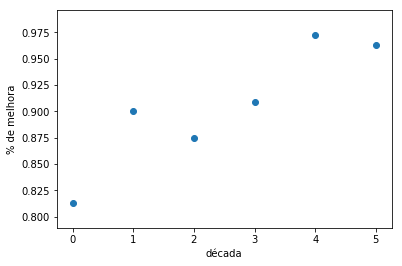

In [10]:
plt.scatter(range(len(proporcao)), proporcao)
plt.xlabel("década")
plt.ylabel("% de melhora")

In [11]:
slope, intercept, r_value, p_value, std_err = stats.linregress(range(len(proporcao)), proporcao)
# De acordo com a documentação do stats.linregress, temos:
'''
Two-sided p-value for a hypothesis test whose null hypothesis is
    that the slope is zero, using Wald Test with t-distribution of
    the test statistic.
'''
# A inclinação (slope) é justamente o que temos interesse

'\nTwo-sided p-value for a hypothesis test whose null hypothesis is\n    that the slope is zero, using Wald Test with t-distribution of\n    the test statistic.\n'

In [27]:
p_value

0.012064398367144654

In [80]:
# Outra solução: Teste Qui Quadrado

# Outro teste que podemos fazer para comparar a proporção de de melhora nas 6 décadas é o teste qui-quadrado
# que verifica a independência entre as variáveis "década" (com 6 categorias) e "condição" (com 2 categorias: melhora ou inalterado)
# esse teste verifica se a distribuição de melhora/inalterado é a mesma em todas as décadas

# O teste Qui Quadrado é útil nesse caso em que temos um variável discreta e supomos um valor "esperado",
# ou seja, que seria esperado caso as distribuições de melhora fossem as mesmas nas 6 décadas (hipótese H0)

# Entretanto, esse método apenas compara se as proporções de melhora são iguais entre as 6 décadas (H0) ou se alguma década pelo menos tem uma diferença (Ha)
# Se houver um tendência de crescimento entre as variáveis analisadas, o teste de qui-quadrado pode detectar a diferença, mas não nos
# responde se há tendência de crescimento.

In [12]:
observacoes = pd.DataFrame()
observacoes['melhorado'] = df.groupby('Ano')['cond'].sum()
observacoes['inalterado'] = df.groupby('Ano')['cond'].size() - observacoes['melhorado']
observacoes

,melhorado,inalterado
Ano,,
1951-1960,78,18
1961-1970,63,7
1971-1980,14,2
1981-1990,20,2
1991-2000,322,9
2001-2005,441,17


In [14]:
chi2, p, dof, ex = stats.chi2_contingency(observacoes)

In [15]:
p

1.707158158567985e-08

#### 2) A partir de 2001, que o procedimento ECT foi aprimorado, a porcentagem de melhora ultrapassa 90%?

In [16]:
# 2)

# Aqui temos um problema semelhante ao que vimos na aula passada sobre a eficiência do Sildenafil

# Podemos fazer um teste unicaudal com H0: p = 0.9 versus Ha: p > 0.9

# Note que, neste caso, o Ha está à direita de H0 e, portanto, o p-valor deve ser calculado a partir da cauda direita


n = df.eval('Ano == "2001-2005"').sum()
p_observado = proporcao.loc['2001-2005']
p_valor = 1- stats.norm.cdf(p_observado, .9, np.sqrt(.9 * .1 / n)) # calculado com a cauda da direita
p_valor

3.6322914473974066e-06

In [ ]:
# Com umnível de signigicância de 0,01, por exemplo, pode-se dizer que a proporção de melhora é maior do que 90%

<hr>

#### 3) O número de aplicações é maior no grupo que melhora do que no que não melhora?

In [17]:
df.groupby('condição')['N° Aplicações'].describe()

,count,mean,std,min,25%,50%,75%,max
condição,,,,,,,,
inalterado,55.0,7.945455,6.816152,1.0,3.0,6.0,10.0,33.0
melhorado,938.0,17.540512,22.863918,1.0,8.0,12.0,18.0,364.0


In [55]:
# note que o max do melhorado é bem alto...
# isso será levado em consideração para a gente visualizar os dados

In [18]:
inalterado = df.query('condição == "inalterado"')['N° Aplicações']
melhorado = df.query('condição == "melhorado"')['N° Aplicações']

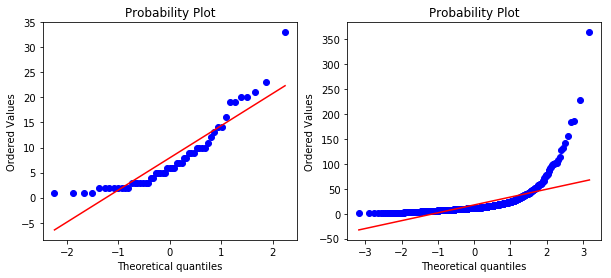

In [19]:
# será que a distribuições são normais?
# se forem, poderemos usar o teste t

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
stats.probplot(inalterado, plot=plt)

plt.subplot(1, 2, 2)
stats.probplot(melhorado, plot=plt)

plt.show()

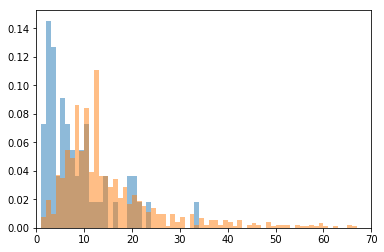

In [20]:
# histograma das distribuições

MAX = 70
plt.hist(inalterado, alpha = .5, density=True, bins = range(MAX + 2))
plt.hist(melhorado, alpha = .5, density=True, bins = range(MAX + 2))

plt.xlim(0, MAX)

plt.show()

In [ ]:
# visualmente os dois parecem distribuições diferentes e não parecem normais

In [ ]:
# OBS: Por que MAX + 2?
# Leve em conta que a função que conta o histograma serve para valores contínuos também
# Essa função precisa definir intervalos de contagem e esses intervalos seguem a seguinte estrutura:
# [A0, A1), [A1, A2), ... , [An-2, An-1), [An-1, An]
# Queremos que o último intervalo seja [70, 71)
# Mas o último intervalor é sempre fechado dos dois lados (padrão do histograma calculado pelo numpy).
# Não queremos [70, 71] como intervalo de contagem,
# então passamos range(70 + 2), para que os últimos intervalos sejam [70, 71), [71, 72]
# e descartamos o último intervalo na hora de visualizar

In [21]:
# Para testar se duas amostras são de distribuições diferentes,
# usaremos o teste não paramétrico Mann–Whitney U
# A hipótese nula é de que as distribuições são iguais.
stats.mannwhitneyu(inalterado, melhorado)

MannwhitneyuResult(statistic=13230.5, pvalue=5.761424067265787e-10)